# ECS Feature Engineering (ECS_FE)

이 노트북은 데이터 엔지니어링 단계로, EDA 결과를 바탕으로 피처 엔지니어링 및 전처리를 수행합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
df = pd.read_csv('./data/Train.csv')
print('Data Shape:', df.shape)
df.head()

Data Shape: (10999, 12)


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


## 2. 불필요 컬럼 제거 (ID)
식별자 ID는 예측에 도움이 되지 않으므로 제거합니다.

In [2]:
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])
    print('ID column dropped.')
else:
    print('ID column not found.')

ID column dropped.


## 3. 파생 변수 생성 (Feature Generation)
변수간 상호작용 및 도메인 지식을 활용해 새로운 변수를 생성합니다.
- **Discount_Rate**: 제품 가격 대비 할인율 (`Discount_offered` / `Cost_of_the_Product`)
- **Cost_per_Weight**: 무게당 비용 (`Cost_of_the_Product` / `Weight_in_gms`)
- **Weight_Segment**: 무게 구간화 (Low, Medium, High, Very High)
- **Discount_High**: 고할인 여부 (>10%)
- **High_Calls_Flag**: 빈번한 고객 문의 여부 (>=5)

In [3]:
# Discount_Rate
df['Discount_Rate'] = df['Discount_offered'] / df['Cost_of_the_Product']

# Cost_per_Weight
df['Cost_per_Weight'] = df['Cost_of_the_Product'] / df['Weight_in_gms']

# Weight_Segment (구간화 세분화)
# 0~2000, 2000~4000, 4000~6000, 6000+
def weight_segment(x):
    if x < 2000:
        return 'Low'
    elif 2000 <= x < 4000:
        return 'Medium'
    elif 4000 <= x < 6000:
        return 'High'
    else:
        return 'Very High'

df['Weight_Segment'] = df['Weight_in_gms'].apply(weight_segment)

# Discount_offered (할인율) - 배송 지연의 핵심 지표
# 할인율이 높으면(예: 10% 이상) 재고 처리/프로모션 가능성 -> 지연 위험
df['Discount_High'] = df['Discount_offered'].apply(lambda x: 1 if x > 10 else 0)

# Customer_care_calls (고객 문의) - 문의가 많으면 이미 지연 중일 확률
# 평균적인 문의 횟수를 초과하는 경우를 별도 플래그로 관리 (예: 5회 이상)
df['High_Calls_Flag'] = df['Customer_care_calls'].apply(lambda x: 1 if x >= 5 else 0)

df[['Cost_of_the_Product', 'Weight_in_gms', 'Discount_offered', 'Discount_Rate', 'Cost_per_Weight', 'Weight_Segment', 'Discount_High', 'High_Calls_Flag']].head()

,Cost_of_the_Product,Weight_in_gms,Discount_offered,Discount_Rate,Cost_per_Weight,Weight_Segment,Discount_High,High_Calls_Flag
0,177,1233,44,0.248588,0.143552,Low,1,0
1,216,3088,59,0.273148,0.069948,Medium,1,0
2,183,3374,48,0.262295,0.054238,Medium,1,0
3,176,1177,10,0.056818,0.149533,Low,0,0
4,184,2484,46,0.250000,0.074074,Medium,1,0


## 4. 범주형 변수 인코딩
모델 학습을 위해 문자를 숫자로 변환합니다.
- **Ordinal Encoding**: 순서가 있는 변수 (`Product_importance`)
- **One-Hot Encoding**: 명목형 변수 (`Warehouse_block`, `Mode_of_Shipment`, `Gender`, `Weight_Segment`)

In [4]:
ordinal_map = {'low': 0, 'medium': 1, 'high': 2}
df['Product_importance'] = df['Product_importance'].map(ordinal_map)

# One-Hot Encoding
categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Gender', 'Weight_Segment']
df_encoded = pd.get_dummies(df, columns=categorical_cols)

print('Encoded Data Shape:', df_encoded.shape)
df_encoded.head()

Encoded Data Shape: (10999, 26)


,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Discount_Rate,Cost_per_Weight,...,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M,Weight_Segment_High,Weight_Segment_Low,Weight_Segment_Medium,Weight_Segment_Very High
0,4,2,177,3,0,44,1233,1,0.248588,0.143552,...,False,True,False,False,True,False,False,True,False,False
1,4,5,216,2,0,59,3088,1,0.273148,0.069948,...,True,True,False,False,False,True,False,False,True,False
2,2,2,183,4,0,48,3374,1,0.262295,0.054238,...,False,True,False,False,False,True,False,False,True,False
3,3,3,176,4,1,10,1177,1,0.056818,0.149533,...,False,True,False,False,False,True,False,True,False,False
4,2,2,184,3,1,46,2484,1,0.250000,0.074074,...,False,True,False,False,True,False,False,False,True,False


## 5. 수치형 변수 스케일링
모든 수치형 변수의 스케일을 맞춥니다 (StandardScaler 사용).

In [5]:
scaler = StandardScaler()
num_cols = ['Cost_of_the_Product', 'Weight_in_gms', 'Discount_offered', 'Prior_purchases', 'Customer_care_calls', 'Customer_rating', 'Discount_Rate', 'Cost_per_Weight']
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

df_encoded.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Discount_Rate,Cost_per_Weight,...,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M,Weight_Segment_High,Weight_Segment_Low,Weight_Segment_Medium,Weight_Segment_Very High
0,-0.047711,-0.700755,-0.690722,-0.372735,0,1.889983,-1.468240,1,1.924300,1.150475,...,False,True,False,False,True,False,False,True,False,False
1,-0.047711,1.421578,0.120746,-1.029424,0,2.815636,-0.333893,1,2.189294,-0.165997,...,True,True,False,False,False,True,False,False,True,False
2,-1.799887,-0.700755,-0.565881,0.283954,0,2.136824,-0.159002,1,2.072196,-0.446982,...,False,True,False,False,False,True,False,False,True,False
3,-0.923799,0.006689,-0.711529,0.283954,1,-0.208162,-1.502484,1,-0.144777,1.257440,...,False,True,False,False,False,True,False,True,False,False
4,-1.799887,-0.700755,-0.545074,-0.372735,1,2.013404,-0.703244,1,1.939539,-0.092202,...,False,True,False,False,True,False,False,False,True,False


## 6. 데이터 확인 및 저장
- Target (`Reached.on.Time_Y.N`)의 분포를 확인합니다.
- 처리된 데이터를 저장합니다.

Target Distribution:
Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64


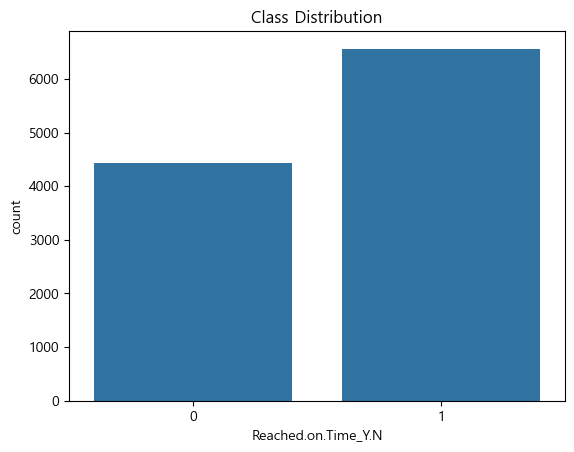

Feature Engineering Completed. Data saved to ./data/Train_FE.csv


In [9]:
print('Target Distribution:')
print(df_encoded['Reached.on.Time_Y.N'].value_counts())

sns.countplot(x='Reached.on.Time_Y.N', data=df_encoded)
plt.title('Class Distribution')
plt.show()

# 저장 필요시 주석 해제
df_encoded.to_csv('./data/Train_FE.csv', index=False)
print('Feature Engineering Completed. Data saved to ./data/Train_FE.csv')

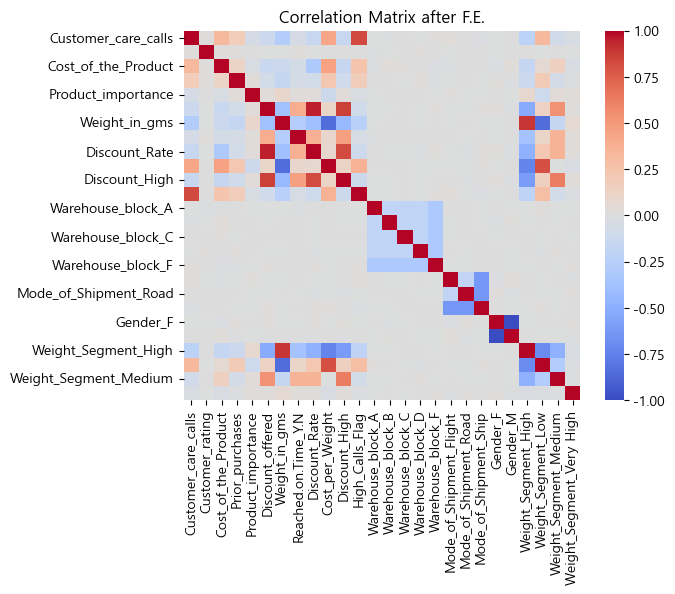

In [7]:
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix after F.E.')
plt.show()
